<a href="https://colab.research.google.com/github/Pr454th/Deep-Learning/blob/main/Convolutional_Neural_Network_with_MNIST_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [11]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import requests
from io import BytesIO
from PIL import Image
import h5py

In [12]:
numb_batch=64

# Getting Data 

In [13]:
T=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_data=torchvision.datasets.MNIST('mnist_data',train=True,download=True,transform=T);
val_data=torchvision.datasets.MNIST('mnist_data',train=False,download=True,transform=T);

train_dl=torch.utils.data.DataLoader(train_data,batch_size=numb_batch)
val_dl=torch.utils.data.DataLoader(val_data,batch_size=numb_batch)

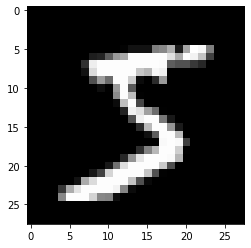

In [14]:
plt.imshow(train_data[0][0][0],cmap="gray")

# Create the Model

In [15]:
def create_lenet():
    model=nn.Sequential(
        nn.Conv2d(1,6,5,padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2,stride=2),
        
        nn.Conv2d(6,16,5,padding=0),
        nn.ReLU(),
        # nn.Softmax(),
        nn.AvgPool2d(2,stride=2),
        
        nn.Flatten(),
        nn.Linear(400,120),
        nn.Linear(120,84),
        nn.Linear(84,10)
    )
    return model

# Validate the Model

In [16]:
def validate(model,data):
    total=0
    correct=0
    for i,(images,labels) in enumerate(data):
        images=images.cuda()
        x=model(images)
        value,pred=torch.max(x,1)
        pred=pred.data.cpu()
        total+=x.size(0)
        correct+=torch.sum(pred==labels)
    return correct*100./total

# Training Function

In [17]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

# GPU availability

In [18]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
else:
    device=torch.device("cpu")

In [19]:
device

device(type='cuda', index=0)

# Training the model

Saving Best Model with Accuracy:  96.75
Epoch: 1 Accuracy : 96.75 %
Saving Best Model with Accuracy:  97.7300033569336
Epoch: 2 Accuracy : 97.7300033569336 %
Saving Best Model with Accuracy:  98.22000122070312
Epoch: 3 Accuracy : 98.22000122070312 %
Saving Best Model with Accuracy:  98.2699966430664
Epoch: 4 Accuracy : 98.2699966430664 %
Saving Best Model with Accuracy:  98.31999969482422
Epoch: 5 Accuracy : 98.31999969482422 %
Saving Best Model with Accuracy:  98.37999725341797
Epoch: 6 Accuracy : 98.37999725341797 %
Saving Best Model with Accuracy:  98.48999786376953
Epoch: 7 Accuracy : 98.48999786376953 %
Saving Best Model with Accuracy:  98.62999725341797
Epoch: 8 Accuracy : 98.62999725341797 %
Saving Best Model with Accuracy:  98.69999694824219
Epoch: 9 Accuracy : 98.69999694824219 %
Epoch: 10 Accuracy : 98.55999755859375 %
Epoch: 11 Accuracy : 98.41999816894531 %
Epoch: 12 Accuracy : 98.55000305175781 %
Epoch: 13 Accuracy : 98.6500015258789 %
Saving Best Model with Accuracy:  98.

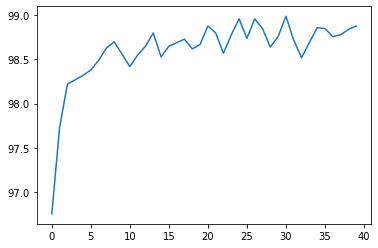

In [20]:
lenet=train(40,device=device)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
def predict_dl(model,data):
  y_pred=[]
  y_true=[]
  for i,(images,labels) in enumerate(data):
    images=images.cuda()
    x=model(images)
    value,pred=torch.max(x,1)
    pred=pred.data.cpu()
    y_pred.extend(list(pred.numpy()))
    y_true.extend(list(labels.numpy()))
  return np.array(y_pred),np.array(y_true)

In [23]:
y_pred,y_true=predict_dl(lenet,val_dl)

In [24]:
pd.DataFrame(confusion_matrix(y_true,y_pred,labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,977,0,1,0,0,0,0,0,1,1
1,0,1132,0,1,0,0,0,0,2,0
2,0,3,1026,0,0,0,0,1,2,0
3,0,2,3,1000,0,4,0,0,1,0
4,0,0,1,0,966,0,5,0,1,9
5,2,1,0,5,0,882,1,1,0,0
6,5,3,0,0,0,1,946,0,3,0
7,0,3,5,1,0,0,0,1016,1,2
8,3,0,4,0,0,1,0,0,964,2
9,0,2,1,0,3,6,1,2,4,990


# Define inference function

In [25]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [26]:
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255

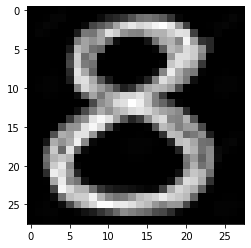

In [27]:
plt.imshow(x.squeeze(-1),cmap="gray")

# Prediction

In [28]:
pred=inference(path,lenet,device=device)
pred_idx=np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 8, Prob: 99.97456669807434 %


In [29]:
pred

array([[3.3738783e-13, 2.4970735e-13, 4.9840443e-09, 2.5159598e-04,
        3.9230048e-13, 1.4538992e-07, 2.6735984e-06, 1.3918841e-13,
        9.9974567e-01, 1.8499635e-17]], dtype=float32)